- https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html#x-learner

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# data

In [2]:
test = pd.read_csv("./data/invest_email_rnd.csv")
train = pd.read_csv("./data/invest_email_biased.csv")
train.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


In [5]:
Y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

# X-learner

In [6]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2)
m1 = LGBMRegressor(max_depth=2)

# propensity score model
g = LogisticRegression() 

m0.fit(train.loc[train[T]==0, X], train.loc[train[T]==0, Y])
m1.fit(train.loc[train[T]==1, X], train.loc[train[T]==1, Y])
                       
g.fit(train[X], train[T]);

In [ ]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[Y],
                   train[Y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2)
mx1 = LGBMRegressor(max_depth=2)

mx0.fit(train.loc[train[T]==0, X], d_train[train[T]==0])
mx1.fit(train.loc[train[T]==1, X], d_train[train[T]==1])

In [8]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]

In [9]:
x_cate_train = (ps_predict(train,0)*mx0.predict(train[X]) +
                ps_predict(train,1)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,0)*mx0.predict(test[X]) +
                                ps_predict(test,1)*mx1.predict(test[X])))

In [12]:
x_cate_test.head()

,age,income,insurance,invested,em1,em2,em3,converted,cate
0,44.1,5483.80,6155.29,14294.81,0,1,1,0,0.066078
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0.104876
2,49.0,2712.51,5707.08,5095.65,1,0,1,1,0.088903
3,39.7,2326.37,15657.97,6345.20,1,1,1,0,0.094290
4,35.3,2787.26,27074.44,14114.86,1,1,1,0,0.169729


# 결과

In [13]:
def elast(data, y, t):
    # line coeficient for the one variable linear regression
    # 해당 data에서 treatment (0 or 1) 에 따른 t의 평균값차이인 것
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

In [19]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # add (rows/size) as a normalizer
    # sample 수에 따라 가중치를 준다 
    # 근데 사실 'size // steps' 으로 동일한 크기라서 큰 차이는 없다
    # 양 끝쪽을 위해 한다고 생각해도 될 듯
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

/tmp/ipykernel_5620/3622750221.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /


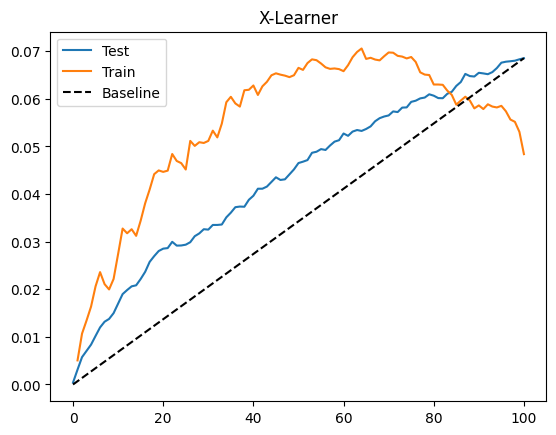

In [20]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");